In [7]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((2,2)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((2,2)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]
def remove_noise(binary_image):
    ret_val = dilate(erode(binary_image))
    ret_val = invert(ret_val)
    return ret_val

    
def create_ann(m_input, output):
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(m_input, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

def prepare_image(path):
    image = load_image(path)
    bin_img = image_bin(image_gray(image))
    bin_img = dilate(bin_img)
    bin_img = erode(bin_img)
    bin_img= erode(bin_img) # potencijalni problem
    bin_img = invert(bin_img);
    return bin_img


def get_area_array_not_sorted(bin_img):
    img, contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    area_matrix = []
    for idx, contour in enumerate(contours): 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area_matrix.append([w*h])
    return area_matrix

def get_area_array_sorted(bin_img):
    img, contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    area_matrix = []
    regions_dict = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        regions_dict[x] = [[w*h], (x,y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values()) 
    for c in sorted_regions[:,0]: 
        area_matrix.append(c)    
    return area_matrix

def start_kmeans(area_matrix):
    k_means = KMeans(n_clusters=2, max_iter=500, init='random', tol=0.00001, n_init=10)
    k_means.fit(area_matrix)
    return k_means

In [8]:
def display_result(results, alphabet, k_means):
    res = ''
    space = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    
    for idx, result in enumerate(results[0:,:]):
        if space == k_means.labels_[idx-1]:
            res += ' '
        
        res += alphabet[winner(results[idx])]
    return res

In [9]:
def rotate_my_regions(contours,angle,center):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    temp = []
    #for angle in angles:
       # if angle != 0:
          #  temp.append(angle)
    #angle = np.mean(temp)
    #print angle
        
    ret_val = []
    for idx, contour in enumerate(contours):
        cx,cy = center
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = abs(angle)
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            #TODO 1 - izračunati koordinate tačke nakon rotacije
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

In [10]:
def merge_regions(contours):
    '''Funkcija koja vrši spajanje kukica i kvačica sa osnovnim karakterima
    Args:
        contours: skup svih kontura (kontura - niz tacaka bele boje)
    Return:
        ret_val: skup kontura sa spojenim kukicama i kvacicama'''
    ret_val = []
    merged_index = [] #lista indeksa kontura koje su već spojene sa nekim

    for i,contour1 in enumerate(contours): #slova
        if i in merged_index:
            continue
        min_x1 = min(contour1[:,0])
        max_x1 = max(contour1[:,0])
        min_y1 = min(contour1[:,1])
        max_y1 = max(contour1[:,1])
        
        list_for_conc = []
        for j,contour2 in enumerate(contours): #kukice
            if j in merged_index or i == j:
                continue
            min_x2 = min(contour2[:,0])
            max_x2 = max(contour2[:,0])
            min_y2 = min(contour2[:,1])
            max_y2 = max(contour2[:,1])
            
            #TODO 2 - izvršiti spajanje kukica iznad slova
            #spajanje dva niza je moguće obaviti funkcijom np.concatenate((contour1,contour2))
            max_height = max(max_y2-min_y2, max_y1-min_y1)
            faktor_visina = 3
            faktor_sirina = 5
            if (abs(min_y1-max_y2)<faktor_visina*max_height or abs(max_y1-min_y2)<faktor_visina*max_height):   #razmak u zavisnosti od visine slova  if (max_x2+min_x2)/2>min_x1 and (max_x2+min_x2)/2<max_x1:
                if min_x2>min_x1-faktor_sirina and max_x2<max_x1+faktor_sirina:
                    list_for_conc.append(contour1)
                    list_for_conc.append(contour2)
                    #ret_val.append(np.concatenate((contour1,contour2)))
                    merged_index.append(i)
                    merged_index.append(j)
         
        if(len(list_for_conc) > 0):
            ret_val.append(np.concatenate(np.asarray(list_for_conc)))
                    
    #svi regioni koji se nisu ni sa kim spojili idu u listu kontura, bez spajanja
    for idx,contour in enumerate(contours):
        if idx not in merged_index:
            ret_val.append(contour)
        
    return ret_val

In [11]:
def select_my_roi(image_orig, image_bin, angle):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im = image_orig.copy()
    
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    letter_centers = []
    
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        
        
        xt,yt,w,h = cv2.boundingRect(contour)
        #proba
        cv2.rectangle(image_orig,(xt,yt),(xt+w,yt+h),(0,255,0),2)
        #kraj probe
        '''if(h*w < 100):
            continue'''
            
        region_points = []
        for i in range (xt,xt+w):
            for j in range(yt,yt+h):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
                  
        if(w*h > 500):
            letter_centers.append(center)
            
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
        
    #print contour_centers
    sorted_cent = sorted(contour_centers, key=lambda x: x[0])
    sorted_leters_centers = sorted(letter_centers, key=lambda x: x[0])
    #PRIPREMA ZA REGRESIJU
    
    
    x = []
    y = []
    for c in sorted_leters_centers:
        x.append(c[0])
        y.append(c[1])
    
    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    x = np.array(x)
    y = np.array(y)
    print y 
    A = np.vstack([x,np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0] # REGRESIJOM DOBIJAMO KOEFICIJENAT PRAVCA
    
    plt.plot(x, y, 'o', label='Podaci', markersize=10)
    plt.plot(x, m*x + c, 'r', label='Fitovana linija')
    plt.legend()
    plt.show()
    contours = rotate_my_regions(contours, angle, sorted_leters_centers[0])
    print 'broj kontura posle rotate: ', len(contours)
    contours = merge_regions(contours)
    print 'broj kontura posle merge: ', len(contours)
   
    
    
    
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            region[y-min_y,x-min_x] = 255
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
        

        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    temp = []
    for r in region_distances:
        temp1 = []
        temp1.append(r)
        temp.append(temp1)
    region_distances = temp
    
    return image_orig, sorted_regions[:, 0], region_distances

[ 288.5         294.5         288.18927002  288.          287.
  286.37210083  287.          286.          286.          291.5         286.
  285.          285.          285.5         284.          284.
  288.75872803  283.          283.          282.37124634  282.5         282.5
  282.5         280.5         281.5         279.96661377]


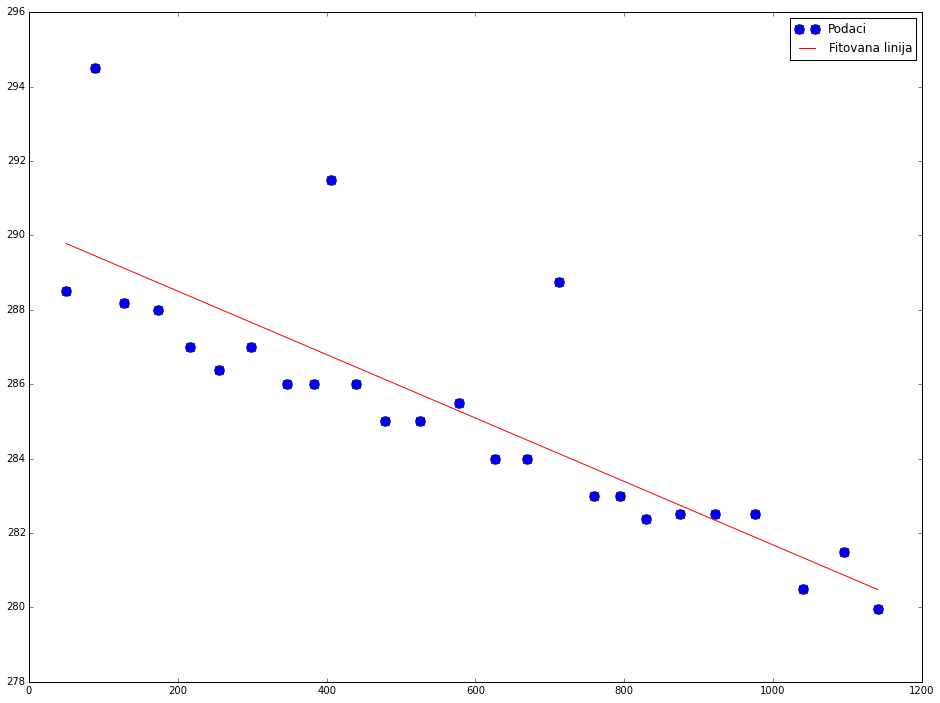

broj kontura posle rotate:  46
broj kontura posle merge:  26
26
26 26


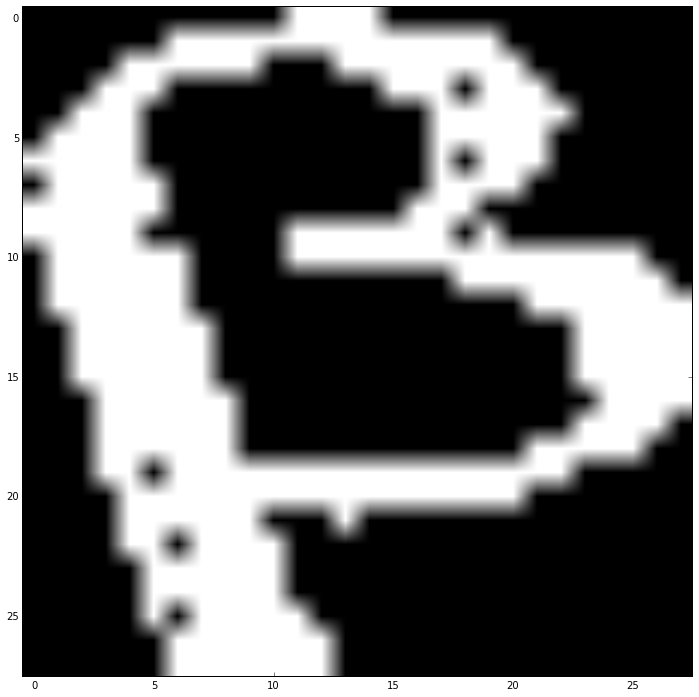

In [12]:
# TRENIRANJE ANE

image_test_original = load_image('train5PRAVA.jpg')
ret,image_bin = cv2.threshold(image_gray(image_test_original.copy()), 127, 255, cv2.THRESH_BINARY)

image_bin = dilate(erode(image_bin))

image_orig, uncategorized_letters, distances = select_my_roi(image_test_original.copy(), image_bin, 0)
display_image(uncategorized_letters[1])
print len(uncategorized_letters)
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

inputs = prepare_for_ann(uncategorized_letters)
outputs = convert_output(alphabet)
print len(outputs), len(alphabet)
ann = create_ann(128, len(outputs))
ann = train_ann(ann, inputs, outputs)

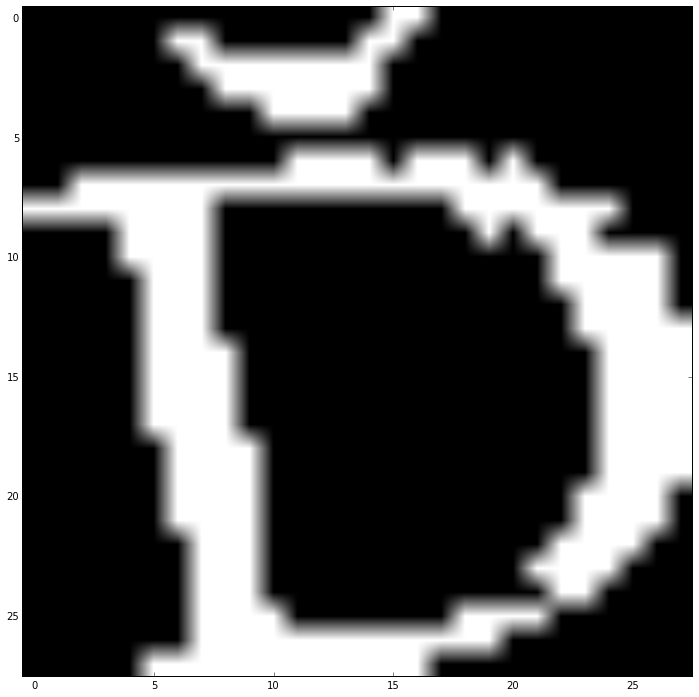

In [13]:
display_image(uncategorized_letters[3])

[ 195.05847168  200.60997009  198.81318665  215.8495636   223.74002075
  228.085495    235.11685181  237.5         252.95942688  252.5
  265.44595337  271.98843384  282.78012085  283.5         298.03979492
  306.453125    316.36376953  316.77328491  323.18511963  328.09368896
  334.66000366  342.5       ]


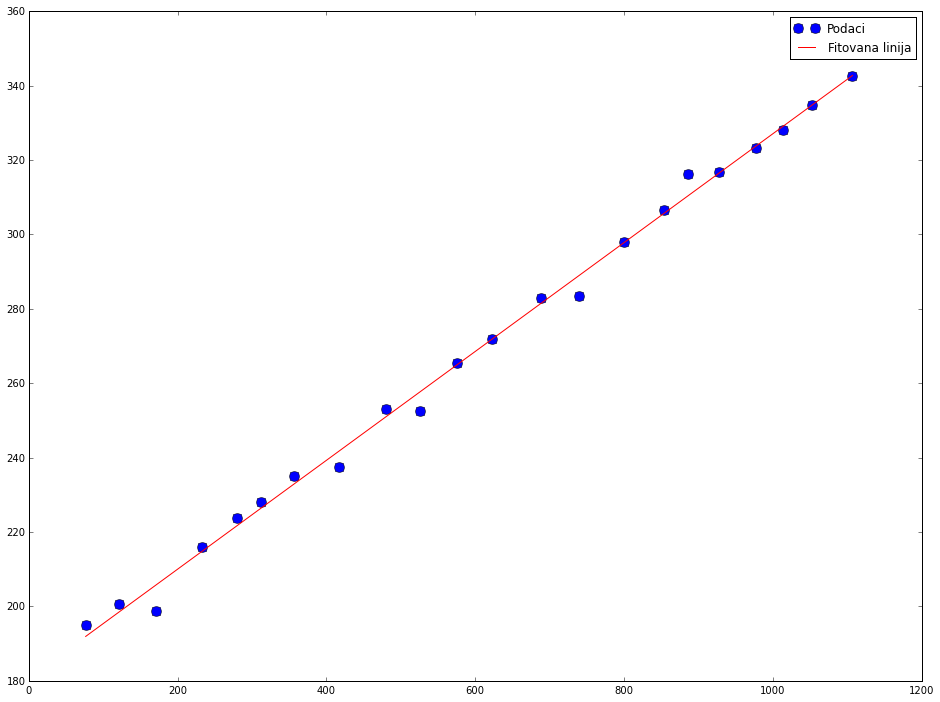

broj kontura posle rotate:  65
broj kontura posle merge:  26


In [14]:
#PREPOZNAVANJE 

image_test = load_image('test5.jpg')
ret,image_bin = cv2.threshold(image_gray(image_test.copy()), 127, 255, cv2.THRESH_BINARY)

image_bin = dilate(erode(image_bin))
image_bin = 255 -image_bin


selected_regions, uncategorized_letter, real_distances = select_my_roi(image_test.copy(), image_bin, 25)
k_means = start_kmeans(real_distances)
inputs = prepare_for_ann(uncategorized_letter)
results = ann.predict(np.array(inputs, np.float32))


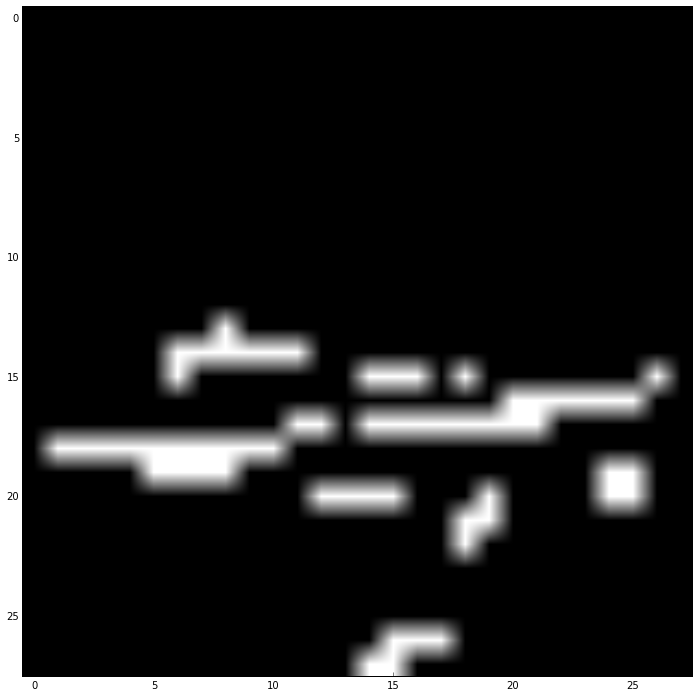

In [15]:
#ISPROBAVANJE ISCRTAVANJA POJEDINACNIH SLOVA

display_image(uncategorized_letter[1])


In [16]:
#ISPIS KONACNOG TEKSTA

print display_result(results, alphabet, k_means)

UVNVWQPVQV TVJQOQVL NSQQNJ VB


-0.0246864484105 0.238785091585 -0.0246814354322


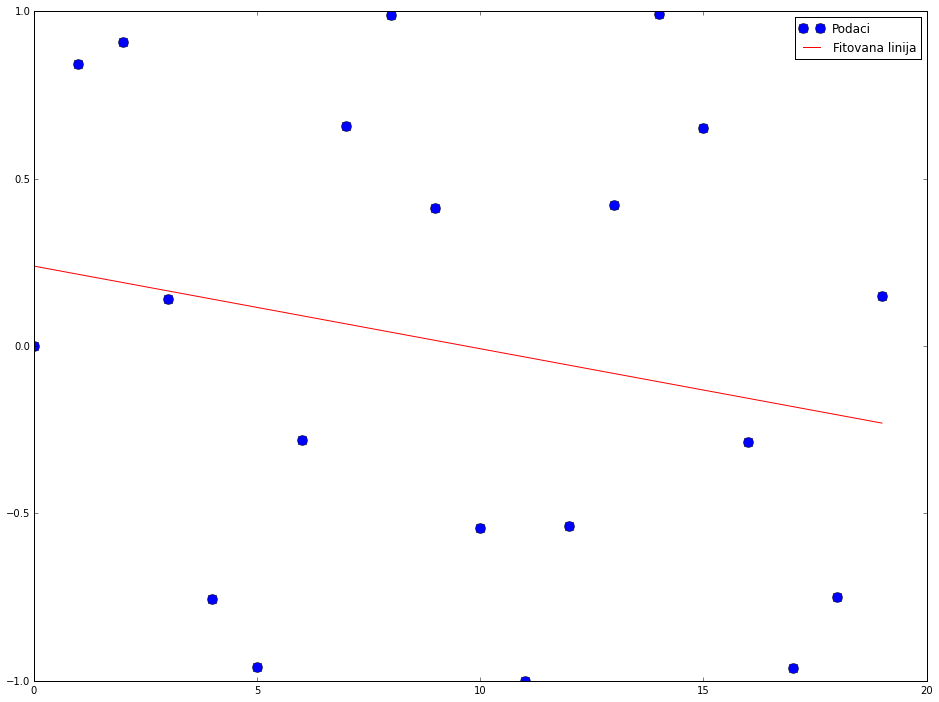

In [17]:
x = range(0, 20, 1)
y = np.sin(x)
x = np.array(x)
y = np.array(y)
A = np.vstack([x,np.ones(len(x))]).T
c, m = np.linalg.lstsq(A, y)[0] # REGRESIJOM DOBIJAMO KOEFICIJENAT PRAVCA

print c, m, np.arctan(c)
plt.plot(x, y, 'o', label='Podaci', markersize=10)
plt.plot(x, c*x + m, 'r', label='Fitovana linija')
plt.legend()
plt.show()